# DTMC

In [1]:
from switss.model import DTMC
import numpy as np
from switss.utils import color_from_hash

# example on how to retrieve SCCs from a DTMC
# setup the graph
# ----------------
E = [[0,1],[1,2],[2,0],[3,2],[3,1],[3,5],[4,2],[4,6],[5,4],[5,3],[6,4],[7,5],[7,6],[7,7]]
P = np.zeros(shape=(8,8))
for u,v in E:
    # initialize with arbitrary probabilities
    ucount = len([w for w,z in E if w == u])
    P[u,v] = 1/ucount
# ----------------

# create DTMC
dtmc = DTMC(P)

print("Transitions:")
print(dtmc.P)

Transitions:
  (0, 1)	1.0
  (1, 2)	1.0
  (2, 0)	1.0
  (3, 1)	0.3333333333333333
  (3, 2)	0.3333333333333333
  (3, 5)	0.3333333333333333
  (4, 2)	0.5
  (4, 6)	0.5
  (5, 3)	0.5
  (5, 4)	0.5
  (6, 4)	1.0
  (7, 5)	0.3333333333333333
  (7, 6)	0.3333333333333333
  (7, 7)	0.3333333333333333


MEC amount: 6


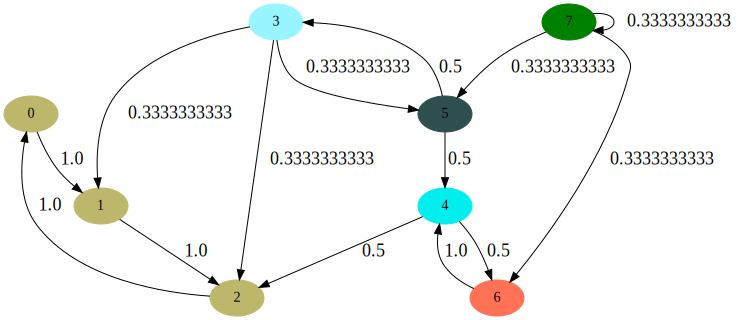

In [2]:
# using the example-DTMC above, we can retrieve its MECs.
components,proper_mecs,mec_counter = dtmc.maximal_end_components()
print("MEC amount:", mec_counter)

def sm(stateidx,labels):
    # give every state a green color that is not part of any MEC
    color = "green" if components[stateidx] == 0 else color_from_hash(7*components[stateidx])
    return { "color" : color, "style" : "filled" } 

dtmc.digraph(state_map=sm)

In [3]:
from switss.utils.graph_utils import underlying_graph

dtmc_graph = underlying_graph(dtmc.P)

In [4]:
from switss.utils.graph_utils import mec_quotient

quotient_MEC_graph,component_members = mec_quotient(dtmc_graph, components, mec_counter)


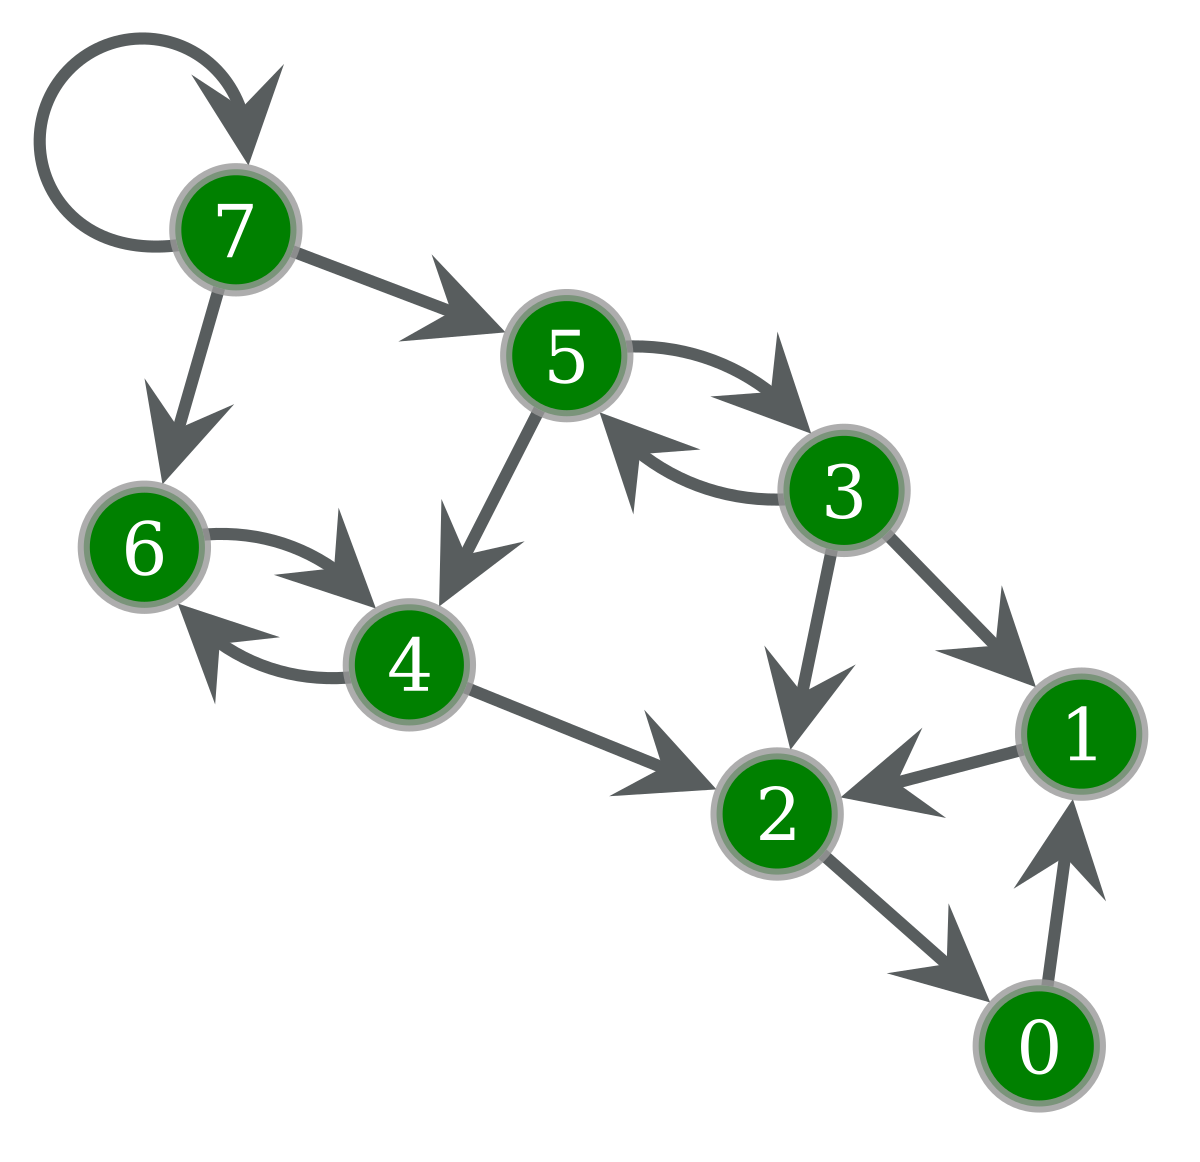

MEC A:  [7] 
MEC B:  [3] 
MEC C:  [5] 
MEC D:  [6] 
MEC E:  [4] 
MEC F:  [0, 1, 2] (PROPER)


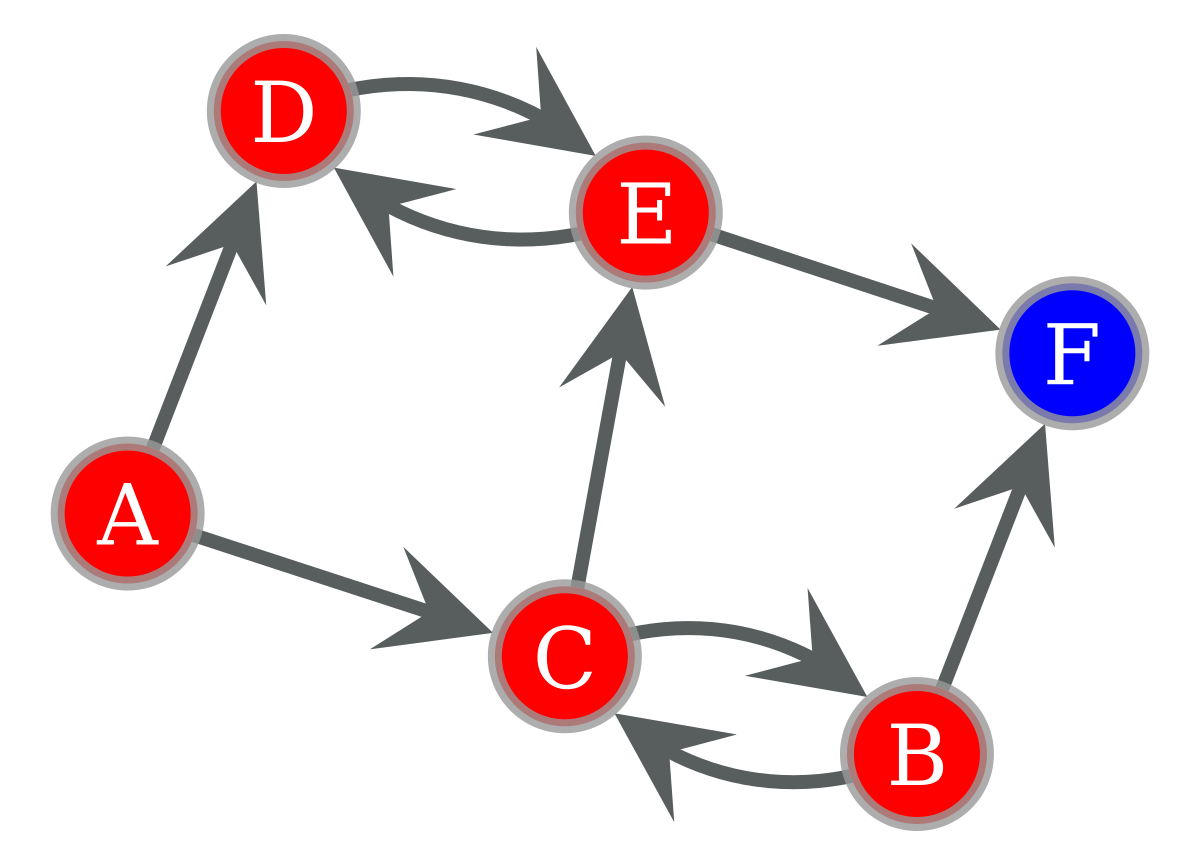

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ffb7a23fdd0, at 0x7ffb7a28e600>

In [9]:
import graph_tool.all as gt

v_names = quotient_MEC_graph.new_vertex_property("string")
for mec_component in range(mec_counter):
    v_names[mec_component] = chr(ord('A') + mec_component)

v_color = quotient_MEC_graph.new_vertex_property("string")
for mec_component in range(mec_counter):
    v_color[mec_component] = 'blue' if proper_mecs[mec_component] else 'red'

gt.graph_draw(dtmc_graph, vertex_text=dtmc_graph.vertex_index, vertex_fill_color='green', bg_color=[1,1,1,1])

for mec_component in range(mec_counter):
    print(f'MEC {v_names[mec_component]}: ', component_members[mec_component], '(PROPER)' if proper_mecs[mec_component] else '')

gt.graph_draw(quotient_MEC_graph, vertex_text=v_names, vertex_fill_color=v_color, bg_color=[1,1,1,1])



# MDP

In [6]:
# from switss.model import MDP
# import numpy as np
# from switss.utils import color_from_hash

# # example on how to retrieve SCCs from a MDP
# # setup the graph
# # ----------------
# SAPpairs = [(0,0,1,1),(1,0,2,1),(2,0,0,1),(3,0,2,1),(4,0,2,0.5),(3,1,5,1),(5,1,3,1),(5,0,4,1),(4,0,6,0.5),(6,0,4,1),(7,1,6,0.5),(7,1,5,0.5),(7,0,7,1)]
# index_by_state_action = {(0,0):0,(1,0):1,(2,0):2,(3,0):3,(4,0):4,(3,1):5,(5,1):6,(5,0):7,(6,0):8,(7,1):9,(7,0):10}
# P = np.zeros(shape=(11,8))
# for s,a,d,p in SAPpairs:
#     P[index_by_state_action[(s,a)],d] = p
# # ----------/------

# # retrieve SCCs
# mdp = MDP(P,index_by_state_action)

# print("Transitions:")
# print(mdp.P)



In [7]:
# components,proper_mecs,mec_counter = mdp.maximal_end_components()
# print("components:",components,"proper Mecs:", proper_mecs, "MEC amount:", mec_counter)

# def sm(stateidx,labels):
#     # give every state a green color that is not part of any MEC
#     color = "green" if components[stateidx] == 0 else color_from_hash(7*components[stateidx])
#     return { "color" : color, "style" : "filled" } 

# mdp.digraph(state_map=sm)